# RTM Example with dynamic scheduling showing wavefield separation
We will perform RTM using the following steps:
1. Read the 10m resampled models output from the FWI notebook
2. Visualize the model
3. Build a small local compute cluster (2 workers)
4. Create list of shot locations 
5. Define the `timemute!`, `migrateshot`, and `stack` functions
6. Run the migration and write individual shot images to disk
7. Stack the individual shot images 
8. Perform a little post migration processing
9. Visualize Results

#### Note on runtime
This notebook takes approximately 20 minutes to run for 100 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

In [1]:
# ]add Optim LineSearches

## Add required packages

In [1]:
using Distributed, PyPlot, Jets, JetPack, JetPackDSP, Printf

## Record time for start of notebook

In [2]:
time_beg = time()

1.603744221313886e9

## 1. Read the 10m resampled models output from the FWI notebook

In [3]:
file1 = "../50_fwi/marmousi_resampled_10m_349x1701_vtrue.bin"

nz,nx = 349,1701
dz,dx = 10.0,10.0

v1_orig = read!(file1, Array{Float32}(undef,nz,nx));

####  Apply a 7x7 rectangular mix smoother
We perform the RTM migration in a slightly smoothed model.

In [4]:
ns = 21
P = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=true)
M = JopMix(range(P), (7,7))
R = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=false)

s1 = R' ∘ M ∘ P * (1 ./ v1_orig)

v1 = 1 ./(s1);

#### Compute "reflectivity" by vertical numerical derivative

In [5]:
D = JopDifference(JetSpace(Float32,nz,nx), 1)
r1 = D * v1;

## 2. Visualize the velocity and reflectivity

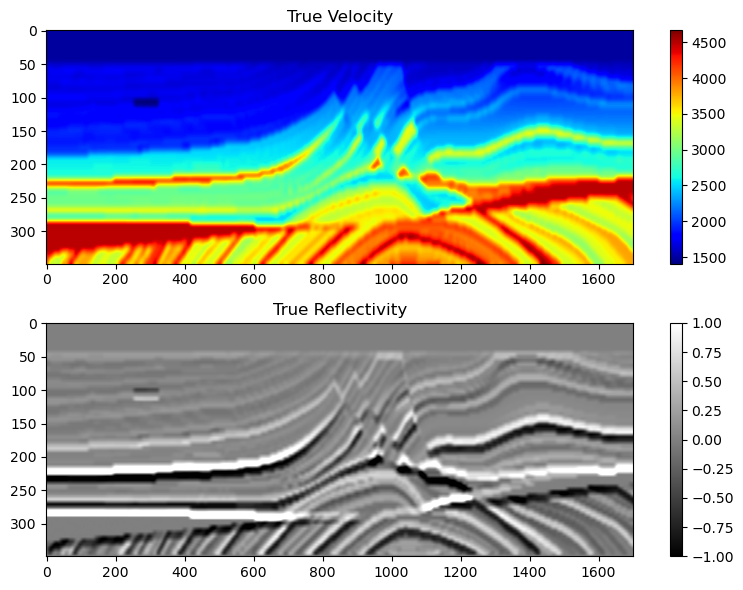

(vmin, vmax, rmax) = (1405.7601f0, 4667.2783f0, 199.77002f0)


In [6]:
vmin,vmax = extrema(v1)
rmax = maximum(abs,r1)
@show vmin,vmax,rmax;
figure(figsize=(8,6)); clf()

subplot(2,1,1); imshow(v1,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("True Velocity");

subplot(2,1,2); imshow(2 .* r1 ./ rmax,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("True Reflectivity");

tight_layout()

## 3. Build a small local compute cluster (2 workers) 

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [7]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, nthread) = (0, 21, 44)
(place1, place2, nthread) = (22, 43, 44)


In [8]:
@everywhere using DistributedArrays, DistributedJets, DistributedOperations, Jets, JetPack, WaveFD, JetPackWaveFD, Random, LinearAlgebra, Schedulers

      From worker 3:	
      From worker 3:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 3:	  _OPENMP = '201511'
      From worker 3:	  OMP_DYNAMIC = 'FALSE'
      From worker 3:	  OMP_NESTED = 'FALSE'
      From worker 3:	  OMP_NUM_THREADS = '22'
      From worker 3:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 3:	  OMP_PROC_BIND = 'CLOSE'
      From worker 3:	  OMP_PLACES = '{22},{23},{24},{25},{26},{27},{28},{29},{30},{31},{32},{33},{34},{35},{36},{37},{38},{39},{40},{41},{42},{43}'
      From worker 3:	  OMP_STACKSIZE = '0'
      From worker 3:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 3:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 3:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 3:	  OMP_CANCELLATION = 'FALSE'
      From worker 3:	  OMP_DEFAULT_DEVICE = '0'
      From worker 3:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 3:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 3:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From wor

## 4. Create list of shot locations 
We use 100 shot locations, many times than our FWI example, and run at significantly higher frequency. 

In [9]:
nshots = 100
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=nshots)));
@show nshots;
@show sx;

nshots = 100
sx = [0, 172, 343, 515, 687, 859, 1030, 1202, 1374, 1545, 1717, 1889, 2061, 2232, 2404, 2576, 2747, 2919, 3091, 3263, 3434, 3606, 3778, 3949, 4121, 4293, 4465, 4636, 4808, 4980, 5152, 5323, 5495, 5667, 5838, 6010, 6182, 6354, 6525, 6697, 6869, 7040, 7212, 7384, 7556, 7727, 7899, 8071, 8242, 8414, 8586, 8758, 8929, 9101, 9273, 9444, 9616, 9788, 9960, 10131, 10303, 10475, 10646, 10818, 10990, 11162, 11333, 11505, 11677, 11848, 12020, 12192, 12364, 12535, 12707, 12879, 13051, 13222, 13394, 13566, 13737, 13909, 14081, 14253, 14424, 14596, 14768, 14939, 15111, 15283, 15455, 15626, 15798, 15970, 16141, 16313, 16485, 16657, 16828, 17000]


## 5. Define the `timemute!`, `migrateshot`, and `stack` functions
* `timemute!` mutes data to remove the direct arrival and refraction
* `migrateshot` runs the migrations for each shot and writes image and illumination files to scratch disk
* `stack` reads in shots from disk and stacks them

**TODO:** convert the IO to use CloudSeis as proxy for cloud storage

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [10]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

#### Global variables for number of samples and sample rate

In [11]:
@everywhere begin
    ntrec = 3001
    dtrec = 0.002
    dtmod = 0.001
end

#### Build the `timemute!` function 

In [12]:
@everywhere function timemute!(F, d, watervel, tmute)
    for i = 1:length(state(F, :rx)) 
        rx = state(F, :rx)
        rz = state(F, :rz)
        sx = state(F, :sx)
        sz = state(F, :sz)
        dist = sqrt((sx[1] - rx[i])^2 + (sz[1] - rz[i])^2)
        time = dist / watervel
        tbeg = 1
        tend = round(Int, (time + tmute) / state(F,:dtrec))
        tend = clamp(tend,1,size(d,1))
        d[tbeg:tend,i] .= 0
    end
    nothing
end

#### Build the `migrateshot` function

In [13]:
# notice we model to significantly shorter time than for FWI
@everywhere function migrateshot(isrc,nz,nx,dz,dx,_vtrue,_v,sx)
    F1 = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=10.0),
        sx = sx[isrc],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        imgcondition = "standard",
        srcfieldfile = joinpath(scratch, "field-$isrc-icstandard-$(randstring()).bin"),
        reportinterval=0)

    F2 = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=10.0),
        sx = sx[isrc],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        imgcondition = "RTM",
        srcfieldfile = joinpath(scratch, "field-$isrc-icrtm-$(randstring()).bin"),
        reportinterval=0)

    d = F1*localpart(_vtrue) #here we model the data usually you would just read the data
    tmute = 6 / (2 * 10)
    timemute!(F1,d,1500,tmute) #mute out the direct and diving waves
    J1 = jacobian!(F1, localpart(_v))
    illum = srcillum(J1)

    @info "migrating shot $(isrc) on $(gethostname()) with id $(myid()) ... IC RTM"
    m1 = J1'*d

    @info "migrating shot $(isrc) on $(gethostname()) with id $(myid()) ... IC standard"
    J2 = jacobian!(F2, localpart(_v))
    m2 = J2'*d
    
    #delete scratch files that we don't need anymore
    close(F1) 
    close(F2)

    write(joinpath(scratch,"image1_$(isrc).bin"),m1)
    write(joinpath(scratch,"image2_$(isrc).bin"),m2)
    write(joinpath(scratch,"illum_$(isrc).bin"),illum)
end

#### Build the `stack` function

In [14]:
function stack(shots,nz,nx)
   img1 = zeros(Float32,nz,nx)
   img2 = zeros(Float32,nz,nx)
   ill = zeros(Float32,nz,nx)
   for isrc in shots
      img1 .+= read!(joinpath(scratch,"image1_$(isrc).bin"), Array{Float32}(undef,nz,nx));
      img2 .+= read!(joinpath(scratch,"image2_$(isrc).bin"), Array{Float32}(undef,nz,nx));
      ill .+= read!(joinpath(scratch,"illum_$(isrc).bin"), Array{Float32}(undef,nz,nx));
   end
   return img1,img2,ill
end

stack (generic function with 1 method)

## 6. Run the migration and write individual shot images to disk

We use epmap to schedule the work for the migration.

In [15]:
# broadcast the models to the workers
_v1 = bcast(v1);

In [16]:
t1 = @elapsed begin
    epmap(i->migrateshot(i, nz, nx, dz, dx, _v1, _v1, sx), 1:nshots)
end
@show t1;

┌ Info: running task 1 on process 2; 2 workers total; 99 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
┌ Info: running task 2 on process 3; 2 workers total; 98 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 2 on cbox-wask-HC44rs with id 3 ... IC RTM
[ Info: migrating shot 1 on cbox-wask-HC44rs with id 2 ... IC RTM
[ Info: migrating shot 1 on cbox-wask-HC44rs with id 2 ... IC standard
[ Info: migrating shot 2 on cbox-wask-HC44rs with id 3 ... IC standard
┌ Info: running task 3 on process 3; 2 workers total; 97 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
┌ Info: running task 4 on process 2; 2 workers total; 96 tasks left in task-pool.
└ @ Schedulers /home/cvx/.julia/dev/Schedulers/src/Schedulers.jl:159
[ Info: migrating shot 3 on cbox-wask-HC44rs with id 3 ... IC RTM
[ Info: migrating shot 4 on cbox-wask-HC44rs with id 2 .

t1 = 2507.841095116


In [17]:
@printf("Time for migrating %.2f minutes\n", t1 / 60)

Time for migrating 41.80 minutes


## 7. Stack the individual shot images 

In [146]:
shots = collect(1:nshots)
m1, m2, illum1 = stack(shots,nz,nx);
@show extrema(m1)
@show extrema(m2)
@show extrema(illum1)

extrema(m1) = (-0.21933396f0, 0.14160573f0)
extrema(m2) = (-0.049212318f0, 0.05372439f0)
extrema(illum1) = (468.26108f0, 35207.453f0)


(468.26108f0, 35207.453f0)

## 8. Perform a little post migration processing

#### Laplacian filter to remove backscattered noise

In [147]:
L = JopHighpass(JetSpace(Float32,nz,nx), nit=(1,1))

"Jet linear operator, (349, 1701) → (349, 1701)"

#### Apply low cut filter, illumination compensation, and gain

In [148]:
g = ([0:(nz-1);]) * ones(Float32,1,nx);
I = g ./ (illum1 .+ 1f-8 * maximum(abs, illum1));

m1 .*= I;
m2 .*= I;
img1 = L * (I .* m1);
img2 = L * (I .* m2);

#### Apply water bottom mute

In [149]:
m1[v1_orig.==1500.0] .= 0;
m2[v1_orig.==1500.0] .= 0;
img1[v1_orig.==1500.0] .= 0;
img2[v1_orig.==1500.0] .= 0;

## 9. Visualize Results

#### Show the raw images
Note that you can see backscattered energy in the top of the raw standard imaging condition result below that is not present in the raw wavefield sepaaration imaging condition result. 

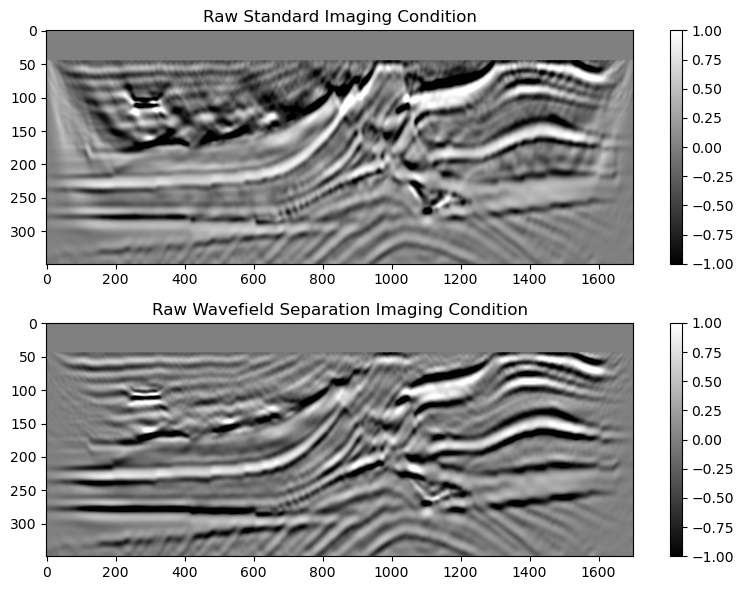

In [150]:
mrms1 = 2.5 * sqrt(norm(m1)^2 / length(m1))
mrms2 = 2.5 * sqrt(norm(m2)^2 / length(m2))

figure(figsize=(8,6)); clf()

subplot(2,1,1); imshow(m1 ./ mrms1,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("Raw Standard Imaging Condition")

subplot(2,1,2); imshow(m2 ./ mrms2,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("Raw Wavefield Separation Imaging Condition")

tight_layout()

#### Show the filtered images

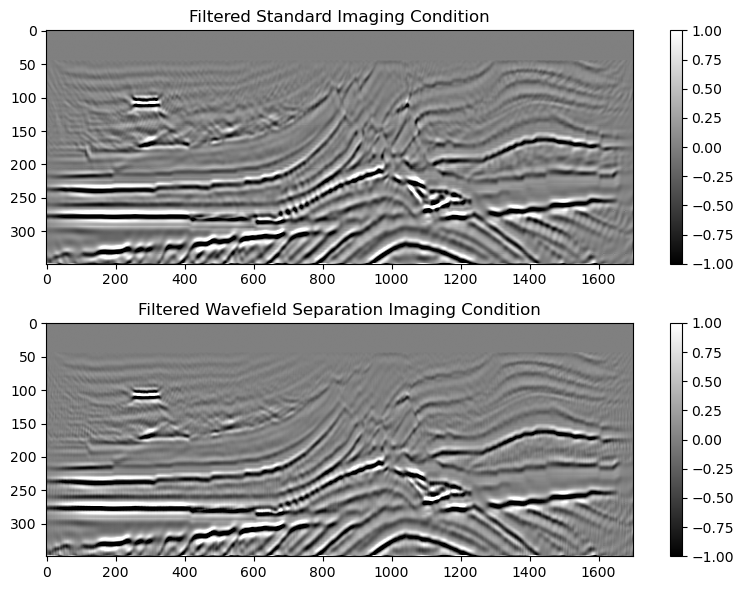

In [151]:
irms1 = 2.5 * sqrt(norm(img1)^2 / length(img1))
irms2 = 2.5 * sqrt(norm(img2)^2 / length(img2))

figure(figsize=(8,6)); clf()

subplot(2,1,1); imshow(img1 ./ irms1,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("Filtered Standard Imaging Condition")

# subplot(2,1,2); imshow(m2 ./ mrms2,aspect="auto",cmap="gray");
# colorbar(orientation="vertical");clim(-1,+1);
# title("Raw Wavefield Separation Imaging Condition")

subplot(2,1,2); imshow(img2 ./ irms2,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-1,+1);
title("Filtered Wavefield Separation Imaging Condition")

tight_layout()

## Remove workers

In [152]:
# rmprocs(workers())

## Delete scratch files

In [153]:
# for isrc in shots
#   rm(joinpath(scratch,"image1_$(isrc).bin"))
#   rm(joinpath(scratch,"image2_$(isrc).bin"))
#   rm(joinpath(scratch,"illum_$(isrc).bin"))
# end

In [154]:
time_end = time()
@sprintf("Time to run notebook; %.2f minutes\n", (time_end - time_beg) / 60)

"Time to run notebook; 89.84 minutes\n"